In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.pipelines.deconvolution import smooth_area_to_point_pk
from pyinterpolate.processing.preprocessing.blocks import Blocks, PointSupport
from pyinterpolate.variogram.regularization.deconvolution import Deconvolution
from pyinterpolate.variogram import build_experimental_variogram, TheoreticalVariogram

import matplotlib.pyplot as plt

In [2]:
areal_data = 'cancer_data.shp'
point_data = 'cancer_population_base.shp'

areal_id = 'FIPS'
areal_val = 'rate'
points_val = 'POP10'
geometry_col= 'geometry'

In [3]:
blocks = Blocks()
blocks.from_file(areal_data, value_col=areal_val, index_col=areal_id)

In [4]:
point_support = PointSupport()
point_support.from_files(point_support_data_file=point_data,
                         blocks_file=areal_data,
                         point_support_geometry_col=geometry_col,
                         point_support_val_col=points_val,
                         blocks_geometry_col=geometry_col,
                         blocks_index_col=areal_id,
                         use_point_support_crs=True)

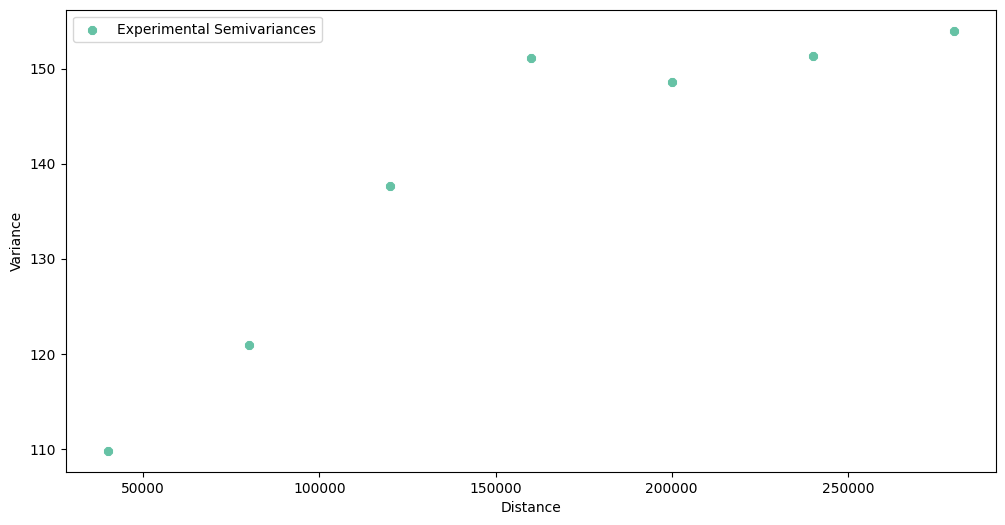

In [5]:
maximum_range = 300000
step_size = 40000

dt = blocks.data[['centroid.x', 'centroid.y', blocks.value_column_name]]  # x, y, val
exp_semivar = build_experimental_variogram(input_array=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

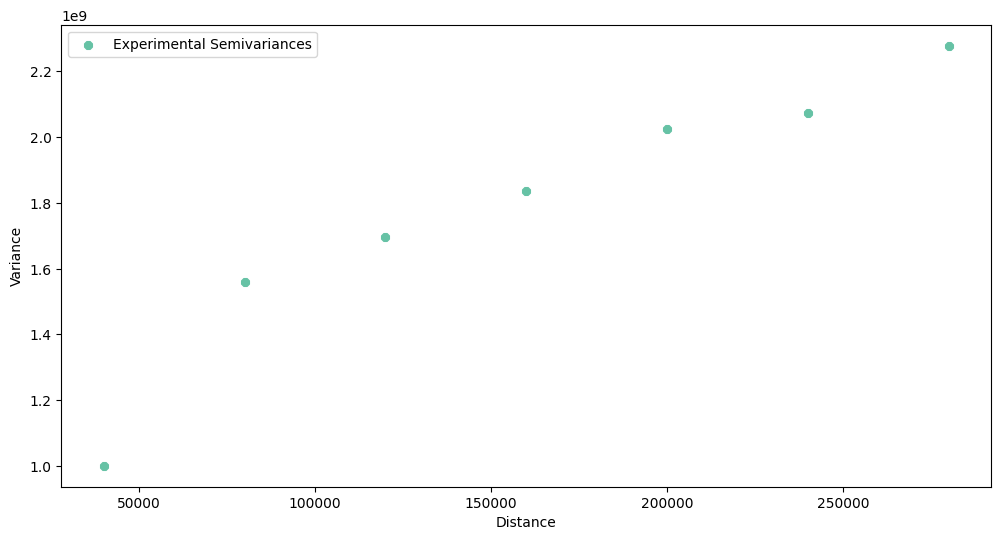

In [6]:
maximum_point_range = 300000
step_size_points = 10000

pt = point_support.point_support[['x', 'y', point_support.value_column]].values
exp_semivar = build_experimental_variogram(input_array=pt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

In [7]:
reg_mod = Deconvolution(verbose=True)
reg_mod.fit(agg_dataset=blocks,
            point_support_dataset=point_support,
            agg_step_size=step_size,
            agg_max_range=maximum_range,
            variogram_weighting_method='closest')

Regularization fit process starts
Regularization fit process ends


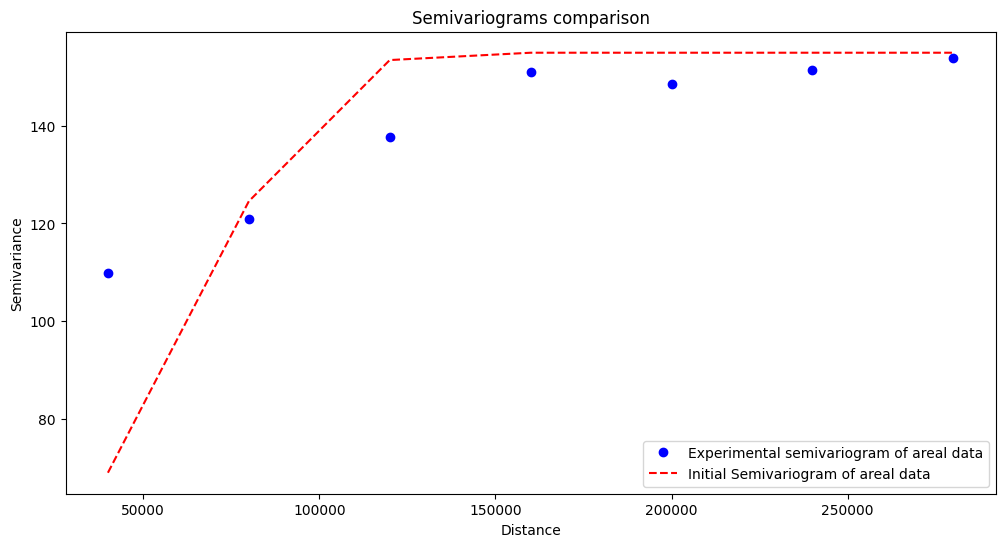

In [8]:
# Check initial experimental and theoretical variograms

reg_mod.plot_variograms()

In [9]:
reg_mod.transform()

Transform procedure starts


100%|███████████████████████████████████████████| 25/25 [01:22<00:00,  3.32s/it]


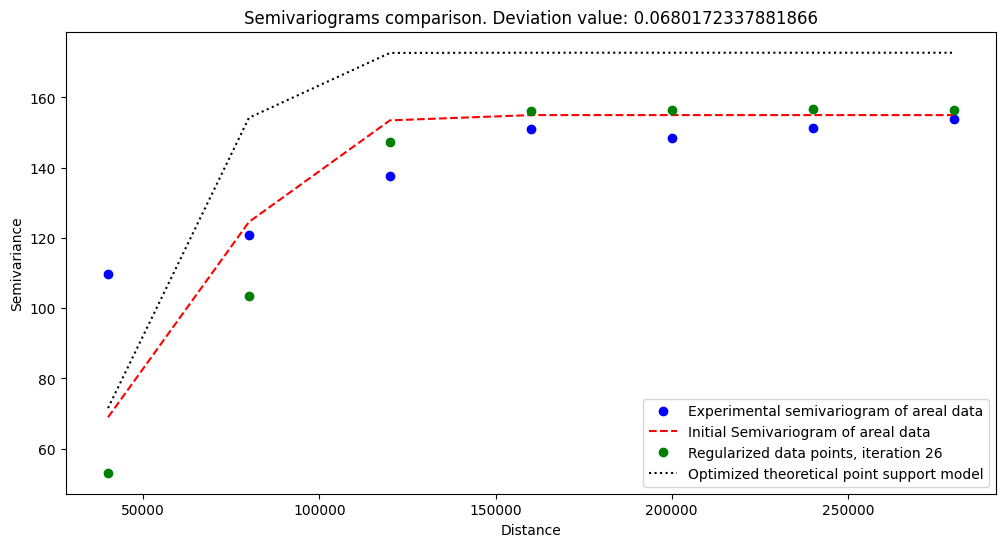

In [10]:
reg_mod.plot_variograms()

In [11]:
reg_mod.export_model('regularized_model')

In [12]:
semivariogram = TheoreticalVariogram()  # Create new variogram
semivariogram.from_json('regularized_model')  # Load regularized semivariogram

In [13]:
number_of_obs = 16
maximum_range = 100000

gdf = smooth_area_to_point_pk(semivariogram_model=semivariogram,
                              blocks=blocks,
                              point_support=point_support,
                              number_of_neighbors=number_of_obs,
                              max_range=maximum_range)

  7%|███                                       | 16/217 [00:01<00:26,  7.56it/s]/home/szymon/miniconda3/envs/p310/lib/python3.10/site-packages/pyinterpolate/kriging/models/block/weight.py:182: RuntimeWarning: invalid value encountered in double_scalars
  weighted_block_smv = weighted_semivars / np.sum(all_weights)
100%|█████████████████████████████████████████| 217/217 [00:40<00:00,  5.38it/s]


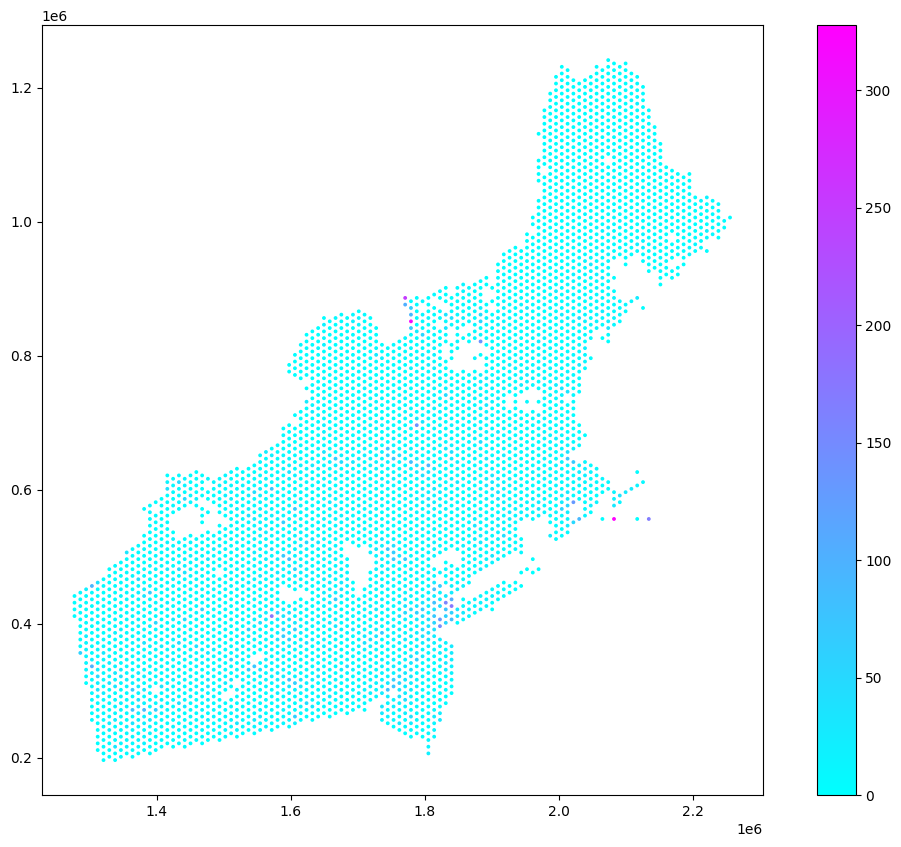

In [14]:
fs = (14, 10)
gdf.plot(column='pred', cmap='cool', legend=True, figsize=fs, s=3)

gdf.to_file('smoothed_output.shp')

___